![alt text](images/bull_market.png)
# Stock Price Prediction Using a Recurrent Neural Network
Author: Elijah Lopez

## Introduction

This notebook is a continuation of my [stock market analysis](eda_notebook.ipynb) where I evaluated performance of Invesco QQQ from Jan 2000 - Dec 2023. During this time I calculated a compounded annual growth rate of 6.29% and found the best performing month to be October. The data for this was obtained from Yahoo Finance and Federal Reserve Economic Data which have been consolidated into a single tabular data frame with no null values under the data.csv file. This data frame contains all numeric features -- of which, the stock data showed almost perfect correlation, except for volume. This data frame will be utilized for stock price prediction going forward.

## Data

In [72]:
# Standard Data Science Toolkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

# Machine Learning Preprocessing and Scoring Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, mean_squared_error, r2_score

import time
import psutil
import os

# Machine Learning Algorithms
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

# Deep Learning
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.random import set_seed
from keras.regularizers import l1, l2, l1_l2

# Saving Models
import pickle

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Set seed for reproducibility
np.random.seed(42)
random.seed(42)
set_seed(42)

In [3]:
# Load data and set date as the index
df = pd.read_csv('data.csv', index_col='date', parse_dates=["date"])
df.drop(columns=['adj_close'], inplace=True)       # Drop adj_close because we are going to predict close
df.head()

,open,high,low,close,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,,,,
2000-01-03,96.1875,96.1875,90.7500,94.75000,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,92.0000,93.5000,87.9375,88.25000,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,87.5000,89.6250,84.2500,86.00000,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,86.8750,88.0000,79.7500,80.09375,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,82.9375,90.0000,82.5000,90.00000,28138200,5.61,7.5,2.826171,4.1,111.3


## Train-Test Split

In [4]:
# Set range (roughly 80% training)
train = df[df.index <= '2018-12-31']
test = df[df.index > '2018-12-31']

In [5]:
# Set close as target and drop from inputs
X_train  = train.copy()
X_train.drop(columns=['close'], inplace=True)
display(X_train.head())

X_test  = test.copy()
X_test.drop(columns=['close'], inplace=True)
display(X_test.head())

,open,high,low,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,,,
2000-01-03,96.1875,96.1875,90.7500,36345200,5.43,7.5,2.826171,4.1,111.3
2000-01-04,92.0000,93.5000,87.9375,33786600,5.38,7.5,2.826171,4.1,111.3
2000-01-05,87.5000,89.6250,84.2500,42496600,5.41,7.5,2.826171,4.1,111.3
2000-01-06,86.8750,88.0000,79.7500,37134800,5.54,7.5,2.826171,4.1,111.3
2000-01-07,82.9375,90.0000,82.5000,28138200,5.61,7.5,2.826171,4.1,111.3


,open,high,low,volume,interest_rate,gdp_growth,inflation_rate,unemployment_rate,consumer_sentiment
date,,,,,,,,,
2019-01-02,150.990005,155.750000,150.880005,58576700,2.4,3.4,1.233584,3.8,93.8
2019-01-03,152.600006,153.259995,149.490005,74820200,2.4,3.4,1.233584,3.8,93.8
2019-01-04,152.339996,157.000000,151.740005,74709300,2.4,3.4,1.233584,3.8,93.8
2019-01-07,156.619995,158.860001,156.110001,52059300,2.4,3.4,1.233584,3.8,93.8
2019-01-08,159.539993,160.110001,157.199997,49388700,2.4,3.4,1.233584,3.8,93.8


In [6]:
# Record close as target
y_train = train.reset_index()
y_train = y_train['close']
display(y_train.head())

y_test = test.reset_index()
y_test = y_test['close']
display(y_test.head())

0    94.75000
1    88.25000
2    86.00000
3    80.09375
4    90.00000
Name: close, dtype: float64

0    154.880005
1    149.820007
2    156.229996
3    158.089996
4    159.520004
Name: close, dtype: float64

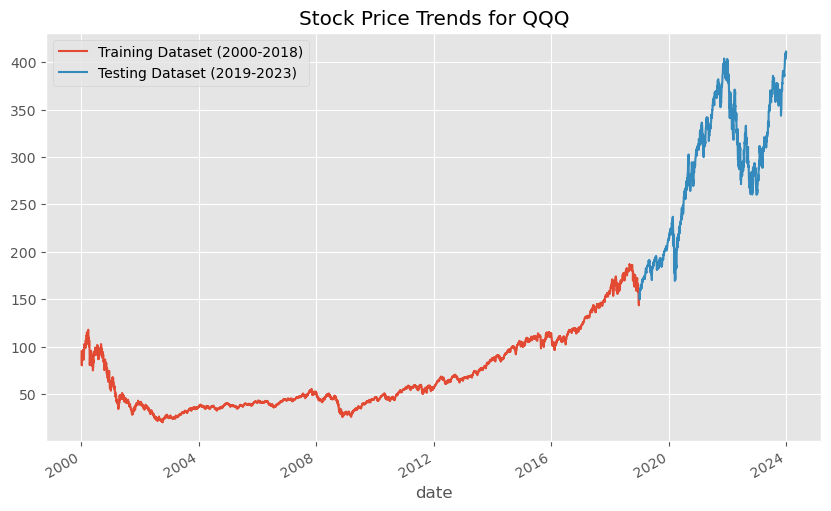

In [7]:
# Visualize training and testing split
df['close'][:'2018-12-31'].plot(figsize=(10,6), legend=True)
df['close']['2019-01-01':].plot(figsize=(10,6), legend=True)

plt.legend(["Training Dataset (2000-2018)", "Testing Dataset (2019-2023)"])
plt.title("Stock Price Trends for QQQ")
plt.show()

## Data Preprocessing

In [8]:
# Scale the train/test data separately
mm_scaler = MinMaxScaler()

X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

## Classical Machine Learning

Use 'shotgun' approach to test baseline performance of various models.

In [9]:
def test_regression_models(X_train, y_train):
    # Adjustments
    CV = 10
    SCORING = 'neg_mean_squared_error' 
    
    # Define the models to be tested
    models = {
        "Lasso": Lasso(),
        "K-Nearest Neighbors": KNeighborsRegressor(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "Support Vector Regressor": SVR()
    }
    
    # Initialize results dictionary to store metrics for each model
    results = {
        "Model": [],
        "Mean Squared Error": [],
        "Spread (std)": [],
        "Train Time (s)": [],
        "Memory Usage (MB)": []
    }
    
    # Perform model evaluation for each model
    for model_name, model in models.items():
        # Measure training time
        start_train_time = time.time()

        # Perform k-fold cross-validation to evaluate the model on the training data
        cv_scores = cross_val_score(model, X_train, y_train, cv=CV, scoring=SCORING)

        end_train_time = time.time()
        train_time = end_train_time - start_train_time

        # Measure memory usage (in MB)
        memory_usage = psutil.Process(os.getpid()).memory_info().rss / (1024 * 1024)
        
        # Convert MSE scores to positive values
        mse_scores = -cv_scores

        # Store the metrics in the results dictionary
        results["Model"].append(model_name)
        results["Mean Squared Error"].append(round(np.mean(mse_scores), 4))
        results["Spread (std)"].append(round(np.std(mse_scores), 4))
        results["Train Time (s)"].append(round(train_time, 4))
        results["Memory Usage (MB)"].append(round(memory_usage, 0))
        
    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results)
    
    # Print the results
    return results_df


In [10]:
test_regression_models(X_train_scaled, y_train)

,Model,Mean Squared Error,Spread (std),Train Time (s),Memory Usage (MB)
0,Lasso,59.3975,143.2306,0.3245,374.0
1,K-Nearest Neighbors,299.1843,444.3264,0.2022,374.0
2,Decision Tree,124.4497,362.4084,1.1592,374.0
3,Random Forest,124.2579,369.7751,77.9208,374.0
4,Gradient Boosting,126.4037,375.5380,22.2994,375.0
5,XGBoost,131.1402,379.3982,1.9357,381.0
6,Support Vector Regressor,274.5504,697.7163,16.4324,378.0


Best performing model was Lasso. Let's see if we can boost performance.

### Lasso

In [11]:
lasso = Lasso()

lasso_param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

In [12]:
lasso_grid_search = GridSearchCV(estimator=lasso, param_grid=lasso_param_grid, cv=5, n_jobs=-1, verbose=True)

In [13]:
lasso_grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             verbose=True)

In [15]:
best_lasso = lasso_grid_search.best_estimator_
best_lasso

Lasso(fit_intercept=False, positive=True)

In [16]:
best_lasso_score = lasso_grid_search.best_score_
best_lasso_score

0.5379099710266931

In [17]:
best_lasso_pred = best_lasso.predict(X_test_scaled)

best_lasso_r2 = r2_score(y_test, best_lasso_pred)
best_lasso_r2

0.9015505935830895

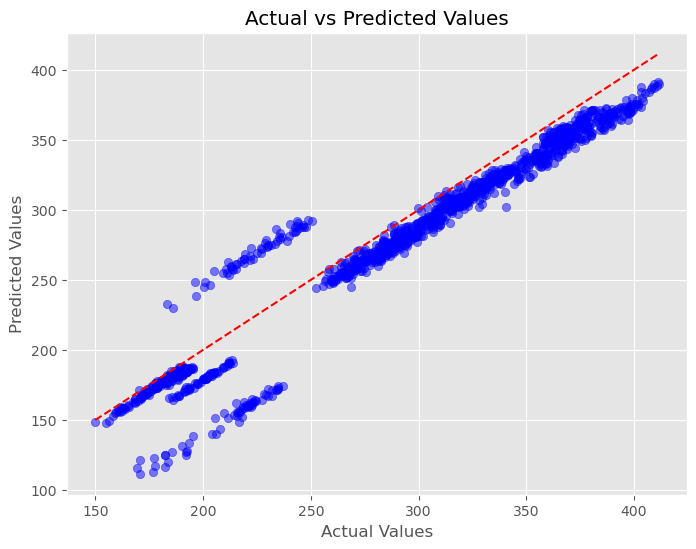

In [ ]:
plt.figure(figsize=(8, 6))

# Scatter plot for actual vs predicted values
x = y_test
y = best_lasso_pred
plt.scatter(x, y, color='blue', alpha=0.5)

# Add title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Line showing perfect predictions
plt.plot([x.min(), x.max()], [x.min(), x.max()], color='red', linestyle='--')

# plt.savefig('images/lasso.png')

plt.show()

### Random Forest

In [19]:
random_forest = RandomForestRegressor(random_state=42)

random_forest_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [20]:
random_forest_grid_search = GridSearchCV(estimator=random_forest, param_grid=random_forest_param_grid, cv=5, n_jobs=-1, verbose=True)

In [21]:
random_forest_grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200]},
             verbose=True)

In [22]:
best_random_forest = random_forest_grid_search.best_estimator_
best_random_forest

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, random_state=42)

In [ ]:
best_random_forest_score = random_forest_grid_search.best_score_
best_random_forest_score

0.6112545646191322

In [24]:
best_random_forest_pred = best_random_forest.predict(X_test_scaled)

In [25]:
best_random_forest_r2 = r2_score(y_test, best_random_forest_pred)
best_random_forest_r2

-2.8718082851668596

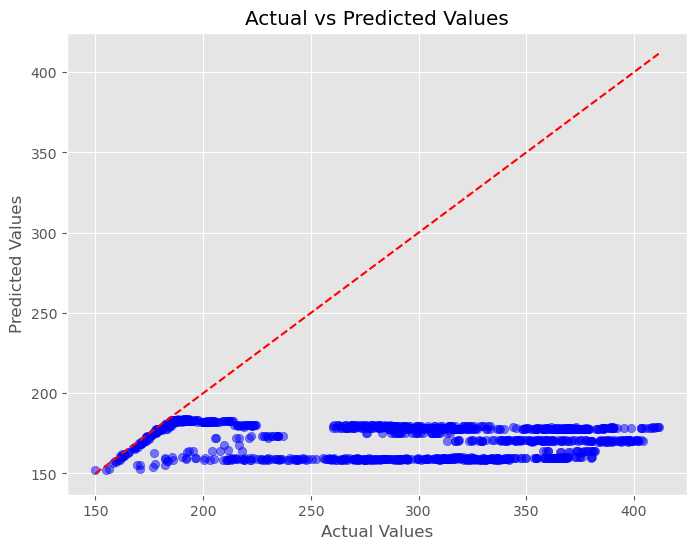

In [ ]:
plt.figure(figsize=(8, 6))

# Scatter plot for actual vs predicted values
x = y_test
y = best_random_forest_pred
plt.scatter(x, y, color='blue', alpha=0.5)

# Add title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')


# Line showing perfect predictions
plt.plot([x.min(), x.max()], [x.min(), x.max()], color='red', linestyle='--')

plt.show();

### Classical Machine Learning Summary

* Lasso performs reasonably well with 90% accuracy
* Random Forest struggles to predict unseen data (once actual value > $180)

## Recurrent Neural network

In [27]:
# Function to create window for given timesteps
def create_window(data, target, timesteps):
    X, y = [], []
    for i in range (timesteps, len(data)):
        X.append(data[i-timesteps: i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [28]:
# Fit to scaled data with timesteps=30
X_train_rnn, y_train_rnn = create_window(X_train_scaled, y_train, 30)
X_test_rnn, y_test_rnn = create_window(X_test_scaled, y_test, 30)

In [29]:
# Used to moderate training and validation time
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,           
    restore_best_weights=True
)

### Simple RNN

In [ ]:
# Model Architecture
simple_rnn = Sequential()

# Layer 1
simple_rnn.add(SimpleRNN(units=50,
                         input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
                         return_sequences=False))

# Output Layer
simple_rnn.add(Dense(1))

# Model Summary
simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                3000      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 3,051
Trainable params: 3,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compilation
simple_rnn.compile(optimizer='adam', loss='mean_squared_error')

# Fit and Validate
simple_rnn_history = simple_rnn.fit(X_train_rnn, y_train_rnn,
                                    epochs=30, batch_size=32,
                                    validation_data=(X_test_rnn, y_test_rnn),
                                    callbacks=[early_stopping])

Epoch 1/30
149/149 [==============================] - 4s 15ms/step - loss: 5030.8599 - val_loss: 81433.3125
Epoch 2/30
149/149 [==============================] - 2s 11ms/step - loss: 4037.9490 - val_loss: 77349.3750
Epoch 3/30
149/149 [==============================] - 2s 13ms/step - loss: 3390.4890 - val_loss: 73826.5312
Epoch 4/30
149/149 [==============================] - 2s 11ms/step - loss: 2892.0728 - val_loss: 70714.5391
Epoch 5/30
149/149 [==============================] - 2s 14ms/step - loss: 2511.0967 - val_loss: 67939.0469
Epoch 6/30
149/149 [==============================] - 2s 11ms/step - loss: 2223.5996 - val_loss: 65526.5547
Epoch 7/30
149/149 [==============================] - 2s 11ms/step - loss: 2011.3854 - val_loss: 63424.5859
Epoch 8/30
149/149 [==============================] - 2s 11ms/step - loss: 1859.3770 - val_loss: 61604.0000
Epoch 9/30
149/149 [==============================] - 2s 14ms/step - loss: 1753.7278 - val_loss: 60089.3672
Epoch 10/30
149/149 [=======

In [32]:
# Function to plot Loss by Epoch
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss by Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    return plt.show()

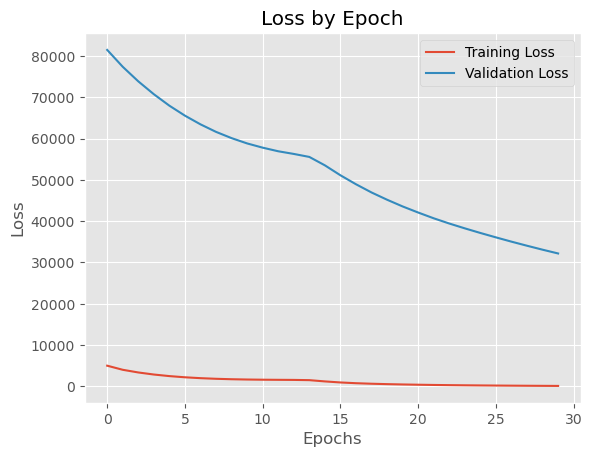

In [33]:
# Visualize loss
plot_loss(simple_rnn_history)

Despite a steady decline in loss for the training function, the model is still failiing to perform well on test data. Minimum validation loss is around 32k.

Let's try LSTM

### Long Short Term Memory (LSTM)

In [ ]:
# Model Architecture
lstm = Sequential()

# Layer 1
lstm.add(LSTM(units=50,
              input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
              return_sequences=False))

# Output Layer
lstm.add(Dense(1))

# Model Summary
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12000     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12,051
Trainable params: 12,051
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compilation
lstm.compile(optimizer='adam', loss='mean_squared_error')

# Fit and Validate
lstm_history = lstm.fit(X_train_rnn, y_train_rnn,
                                    epochs=30, batch_size=32,
                                    validation_data=(X_test_rnn, y_test_rnn),
                                    callbacks=[early_stopping])

Epoch 1/30
149/149 [==============================] - 10s 38ms/step - loss: 4969.8770 - val_loss: 80505.1016
Epoch 2/30
149/149 [==============================] - 4s 29ms/step - loss: 3871.5044 - val_loss: 76395.8438
Epoch 3/30
149/149 [==============================] - 4s 27ms/step - loss: 3242.3284 - val_loss: 72882.8672
Epoch 4/30
149/149 [==============================] - 4s 29ms/step - loss: 2765.9424 - val_loss: 69803.8047
Epoch 5/30
149/149 [==============================] - 5s 31ms/step - loss: 2407.5149 - val_loss: 67075.8906
Epoch 6/30
149/149 [==============================] - 6s 37ms/step - loss: 2141.3879 - val_loss: 64723.9883
Epoch 7/30
149/149 [==============================] - 5s 32ms/step - loss: 1948.3925 - val_loss: 62691.6484
Epoch 8/30
149/149 [==============================] - 4s 27ms/step - loss: 1812.9158 - val_loss: 60946.8594
Epoch 9/30
149/149 [==============================] - 4s 26ms/step - loss: 1720.7382 - val_loss: 59533.5625
Epoch 10/30
149/149 [======

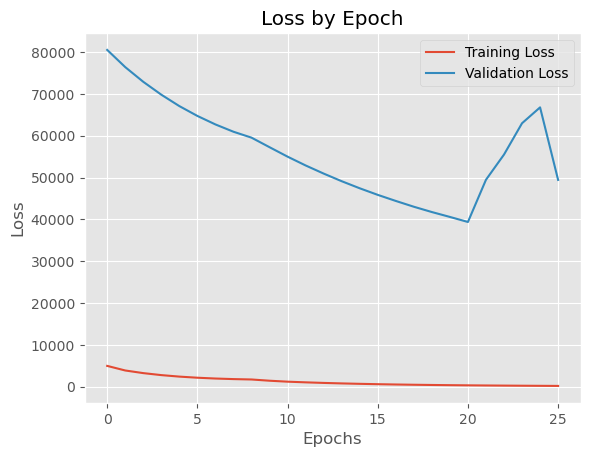

In [ ]:
# Visualize Loss
plot_loss(lstm_history)

Minimum validation loss near 40k. Let's take a look at GRU

### Gated Recurrent Unit (GRU)

In [ ]:
# Model architecture
gru = Sequential()

# Layer 1
gru.add(GRU(units=50,
            input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
            return_sequences=False))

# Output Layer
gru.add(Dense(1))

# Model Summary
gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                9150      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 9,201
Trainable params: 9,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Complilation
gru.compile(optimizer='adam', loss='mean_squared_error')

# Fit and Validate
gru_history = gru.fit(X_train_rnn, y_train_rnn,
                      epochs=30, batch_size=32,
                      validation_data=(X_test_rnn, y_test_rnn),
                      callbacks=[early_stopping])

Epoch 1/30
149/149 [==============================] - 11s 43ms/step - loss: 5038.7324 - val_loss: 80962.7422
Epoch 2/30
149/149 [==============================] - 8s 52ms/step - loss: 3953.1443 - val_loss: 76846.3906
Epoch 3/30
149/149 [==============================] - 5s 33ms/step - loss: 3309.7649 - val_loss: 73308.4609
Epoch 4/30
149/149 [==============================] - 5s 31ms/step - loss: 2821.2891 - val_loss: 70204.5859
Epoch 5/30
149/149 [==============================] - 6s 38ms/step - loss: 2451.9641 - val_loss: 67449.6250
Epoch 6/30
149/149 [==============================] - 5s 32ms/step - loss: 2176.0930 - val_loss: 65067.4219
Epoch 7/30
149/149 [==============================] - 5s 36ms/step - loss: 1974.6283 - val_loss: 63002.3711
Epoch 8/30
149/149 [==============================] - 5s 32ms/step - loss: 1832.0398 - val_loss: 61223.2578
Epoch 9/30
149/149 [==============================] - 5s 32ms/step - loss: 1734.2407 - val_loss: 59754.1445
Epoch 10/30
149/149 [======

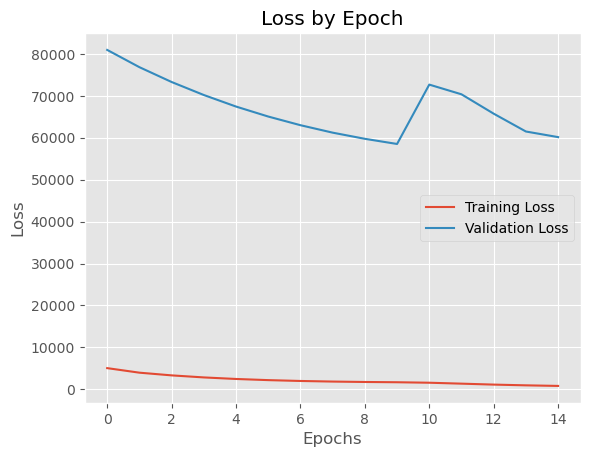

In [ ]:
# Visualize Loss
plot_loss(gru_history)

Minimum validation loss near 58k

The simple RNN and LSTM had the best baseline performance.

Because LSTM is better with more complex data I'll continue building that out to reduce validation loss further.

In [ ]:
# Model Architecture
best_rnn = Sequential()

# Layer 1
best_rnn.add(LSTM(units=50,
                  input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]),
                  return_sequences=True,
                  kernel_regularizer=l1(0.01)))
best_rnn.add(Dropout(0.40))

# Layer 2
best_rnn.add(LSTM(units=50,
                  return_sequences=False,
                  kernel_regularizer=l1(0.01)))
best_rnn.add(Dropout(0.40))

# Dense Layer to Connect Output
best_rnn.add(Dense(units=32))

# Output Layer
best_rnn.add(Dense(1))
best_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 50)            12000     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                1632      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 33,865
Trainable params: 33,865
Non-trai

In [ ]:
# Set SGD as optimizer
optimizer = SGD(learning_rate=0.001, momentum=0.9)

# Compilation
best_rnn.compile(optimizer=optimizer, loss='mean_squared_error')

# Fit and Validate
best_rnn_history = best_rnn.fit(X_train_rnn, y_train_rnn,
                      epochs=30, batch_size=32,
                      validation_data=(X_test_rnn, y_test_rnn),
                      callbacks=[early_stopping])

Epoch 1/30
149/149 [==============================] - 21s 85ms/step - loss: 1898.8687 - val_loss: 62941.5977
Epoch 2/30
149/149 [==============================] - 10s 66ms/step - loss: 1786.0839 - val_loss: 39797.1680
Epoch 3/30
149/149 [==============================] - 9s 59ms/step - loss: 475.3835 - val_loss: 22225.0586
Epoch 4/30
149/149 [==============================] - 10s 68ms/step - loss: 312.1180 - val_loss: 8467.3945
Epoch 5/30
149/149 [==============================] - 10s 69ms/step - loss: 255.9989 - val_loss: 21471.8633
Epoch 6/30
149/149 [==============================] - 10s 67ms/step - loss: 225.7712 - val_loss: 20365.5352
Epoch 7/30
149/149 [==============================] - 10s 67ms/step - loss: 200.1685 - val_loss: 20491.5566
Epoch 8/30
149/149 [==============================] - 10s 69ms/step - loss: 160.1159 - val_loss: 15941.4248
Epoch 9/30
149/149 [==============================] - 9s 61ms/step - loss: 156.2236 - val_loss: 18679.2090


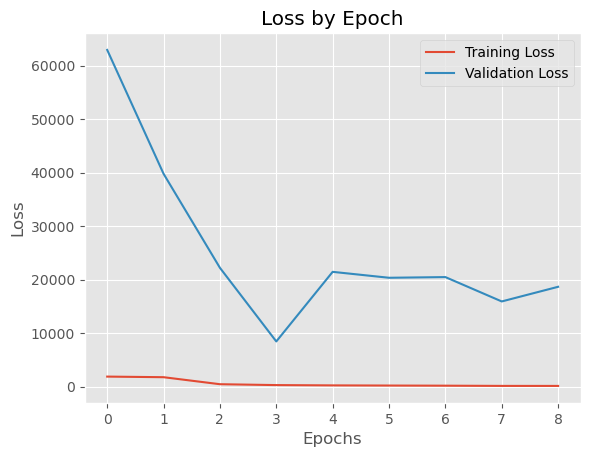

In [ ]:
# Visualize Loss
plot_loss(best_rnn_history)

39/39 [==============================] - 3s 14ms/step


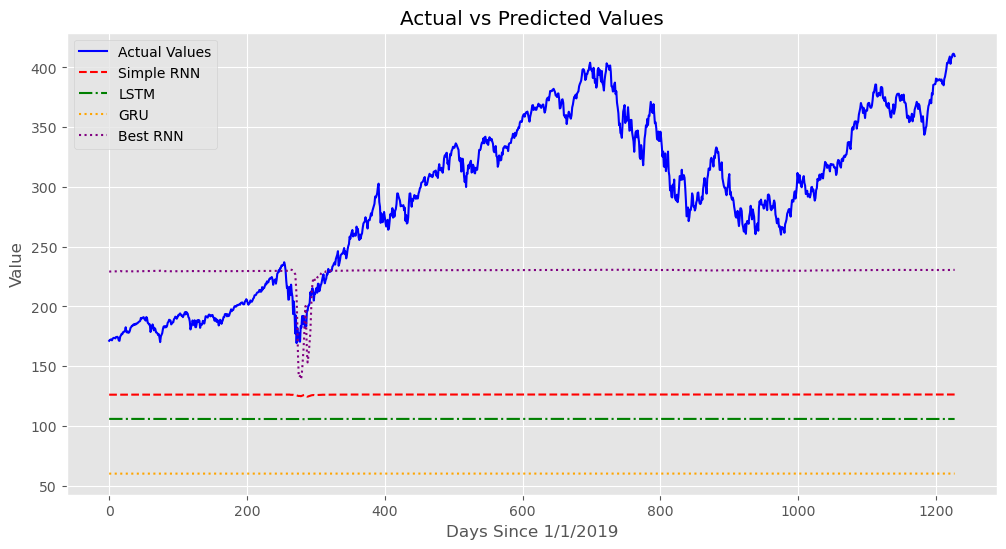

In [ ]:
# Get predictions for each model
simple_rnn_pred = simple_rnn.predict(X_test_rnn)
lstm_pred = lstm.predict(X_test_rnn)
gru_pred = gru.predict(X_test_rnn)
best_rnn_pred = best_rnn.predict(X_test_rnn)

# Plot actual values
plt.figure(figsize=(12,6))
plt.plot(y_test_rnn, label='Actual Values', color='blue')

# Plot predicted values for each model
plt.plot(simple_rnn_pred, label='Simple RNN', color='red', linestyle='--')
plt.plot(lstm_pred, label='LSTM', color='green', linestyle='-.')
plt.plot(gru_pred, label='GRU', color='orange', linestyle=':')
plt.plot(best_rnn_pred, label='Best RNN', color='purple', linestyle='dotted')

# Add title and labels
plt.title('Actual & Predicted Stock Price on Test Data')
plt.xlabel('Days Since 1/1/2019')
plt.ylabel('Stock Price')
plt.legend()
plt.show();

### RNN Summary

Despite using varying complexity of models, estimations are generally flat. This could be due to the challenge of long term stock price estimation.

In [64]:
# Extend the timestep to 100
X_train_rnn_long, y_train_rnn_long = create_window(X_train_scaled, y_train, 100)
X_test_rnn_long, y_test_rnn_long = create_window(X_test_scaled, y_test, 100)

In [65]:
# Model Architecture
ultimate_rnn = Sequential()

# Layer 1
ultimate_rnn.add(LSTM(units=150,
                  input_shape=(X_train_rnn_long.shape[1], X_train_rnn_long.shape[2]),
                  return_sequences=True,
                  kernel_regularizer=l1(0.01)))
ultimate_rnn.add(Dropout(0.40))

# Layer 2
ultimate_rnn.add(LSTM(units=75,
                  return_sequences=False,
                  kernel_regularizer=l1(0.01)))
ultimate_rnn.add(Dropout(0.40))

# Dense Layer
ultimate_rnn.add(Dense(units=32))

# Output Layer
ultimate_rnn.add(Dense(1))

# Model Summary
ultimate_rnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 100, 150)          96000     
                                                                 
 dropout_12 (Dropout)        (None, 100, 150)          0         
                                                                 
 lstm_14 (LSTM)              (None, 75)                67800     
                                                                 
 dropout_13 (Dropout)        (None, 75)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2432      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 166,265
Trainable params: 166,265
Non-tr

In [ ]:
# Optimizer
optimizer = SGD(learning_rate=0.001, momentum=0.9)

# Compilation
ultimate_rnn.compile(optimizer=optimizer, loss='mean_squared_error')

# Fit and Validate
ultimate_rnn_history = ultimate_rnn.fit(X_train_rnn_long, y_train_rnn_long,
                      epochs=30, batch_size=32,
                      validation_data=(X_test_rnn_long, y_test_rnn_long),
                      callbacks=[early_stopping])

Epoch 1/30
147/147 [==============================] - 30s 157ms/step - loss: 1841.8950 - val_loss: 47351.0391
Epoch 2/30
147/147 [==============================] - 25s 173ms/step - loss: 347.9489 - val_loss: 13621.7334
Epoch 3/30
147/147 [==============================] - 28s 194ms/step - loss: 234.4174 - val_loss: 19217.2891
Epoch 4/30
147/147 [==============================] - 29s 198ms/step - loss: 178.2858 - val_loss: 13268.5635
Epoch 5/30
147/147 [==============================] - 30s 206ms/step - loss: 158.1446 - val_loss: 6741.2969
Epoch 6/30
147/147 [==============================] - 32s 218ms/step - loss: 137.5113 - val_loss: 14425.9863
Epoch 7/30
147/147 [==============================] - 33s 226ms/step - loss: 137.8328 - val_loss: 11255.5771
Epoch 8/30
147/147 [==============================] - 37s 249ms/step - loss: 122.1455 - val_loss: 15480.7393
Epoch 9/30
147/147 [==============================] - 30s 204ms/step - loss: 105.0086 - val_loss: 11130.9473
Epoch 10/30
147/147

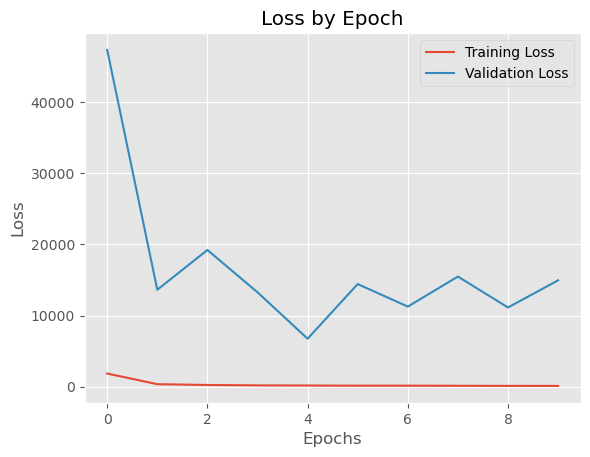

In [ ]:
# Visualize Loss
plot_loss(ultimate_rnn_history)

37/37 [==============================] - 2s 47ms/step


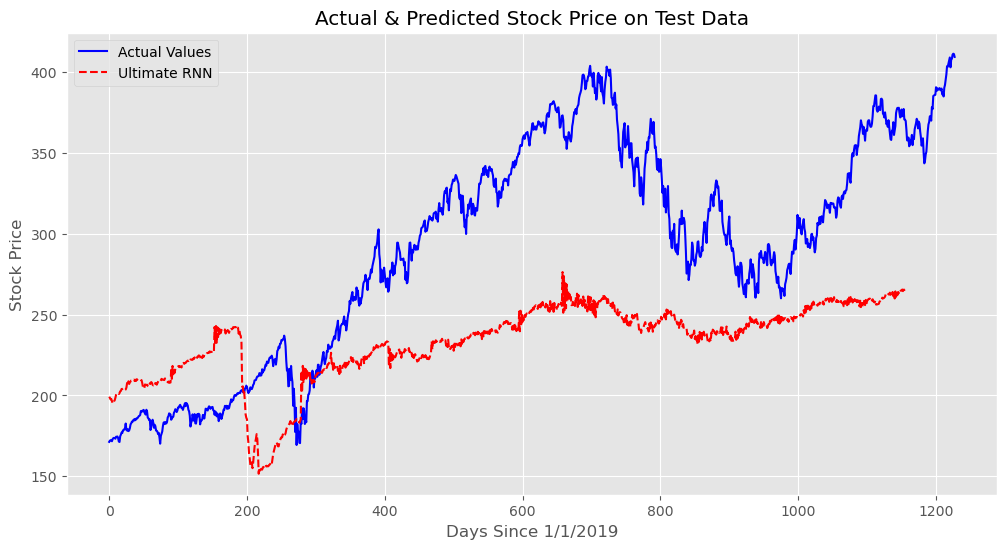

<Figure size 640x480 with 0 Axes>

In [ ]:
# Get predictions for model
ultimate_rnn_pred = ultimate_rnn.predict(X_test_rnn_long)

# Plot actual values
plt.figure(figsize=(12,6))
plt.plot(y_test_rnn, label='Actual Values', color='blue')

# Plot predicted values for each model
plt.plot(ultimate_rnn_pred, label='Ultimate RNN', color='red', linestyle='--')

# Add title and labels
plt.title('Actual & Predicted Stock Price on Test Data')
plt.xlabel('Days Since 1/1/2019')
plt.ylabel('Stock Price')
plt.legend()

# plt.savefig('images/ultimate_rnn.png')

plt.show();

In [ ]:
# # Save Model
# ultimate_rnn.save('model/ultimate_rnn.h5')

# # Save History
# with open('model/ultimate_rnn_history.pkl', 'wb') as file:
#     pickle.dump(ultimate_rnn_history.history, file)

## Results

* Lasso classical algorithm worked well to minimize loss while making accure predictions.
* While RNN was expected to ourperform, more architectural work is needed to boost performance.
* Adjusting time horizon of predictions may allow for more accurate predictions.

## Conclusions

Currently, the Lasso regression model stands as the most effective model in terms of performance. This model's predictive capabilities enable it to offer valuable insights into future stock price movements, providing a reliable foundation for making informed investment decisions. By leveraging this model, users can forecast potential trends and fluctuations in stock prices, thereby positioning themselves to strategically capitalize on market opportunities and maximize financial returns. However, it is important to consider that, while the model provides significant predictive power, continuous refinement and validation are essential for maintaining accuracy and reliability in a dynamic market environment.

## Next Steps

Possible routes for model improvement:
* Utilize technical indicators that help quanitfy variance in stock price movements.
* Incorporate additional macroeconmic data that affects the stock market.
* Shorten the predictive time horizon and use additional recent data for training.